In [2]:
from cohlib.bcn import gen_bcn_params, sample_bcn_time_obs, sample_zs_from_Gamma
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import irfft, rfft
from cohlib.alg.transform import generate_harmonic_dict
from cohlib.utils import conv_real_to_complex, conv_complex_to_real
from cohlib.sample import gen_complex_cov, sample_complex_normal
from cohlib.utils import get_freqs, add_zero


In [3]:
Fs = 1000
time_sec = 1
sample_length = time_sec*Fs
Gamma, freqs = gen_bcn_params(1, Fs=Fs, K=2)
Gamma_mod = Gamma[:50,:,:]
Gamma_mod.shape

supp_inds = np.where((freqs <= 80) & (freqs > 30))[0]
support_filt = np.zeros_like(freqs)
support_filt[supp_inds] = 1

In [32]:
def sample_mcn_time_obs(Gamma, L, freqs, W, dc, return_all=True, support_filt=None):
    K = Gamma.shape[1]
    J = freqs.size
    zs = np.zeros((L,K,J+1),dtype=complex)
    zs[:,:,0] = dc[None,:]
    if Gamma.shape[0] != J:
        num_freqs_Gamma = Gamma.shape[0]
        band_samples = sample_zs_from_Gamma(Gamma, L)
        support_filt_dc = np.zeros(J+1).astype(bool)

        if support_filt is None:
            support_filt_dc[1:num_freqs_Gamma+1] = True
        else:
            support_filt_dc[1:] = support_filt

        zs[:,:,support_filt_dc] = band_samples

    else:
        samples = sample_zs_from_Gamma(Gamma, L)
        zs[:,:,1:] = samples

    vs = np.zeros((L,K,2*J+1))
    for l in range(L):
        for k in range(K):
            vs[l,k,:] = conv_z_to_v(zs[l,k,:])

    xs = np.einsum('ij,abj->abi', Wv, vs)

    if return_all:
        return xs, vs, zs
    else:
        return xs

In [10]:
# def get_real_idft(slen, J, fs, res, frange):
def get_real_idft(slen, J, fs):
    n_elements = slen

    # k_low = int(np.ceil(frange[0]/fs*n_elements))
    # k_end = int(frange[1]/fs*n_elements)
    Jv = int(J*2)+2

    Wv = np.zeros((slen, Jv))
    for t in range(slen):
        for j in range(J+1):
            Wv[t,2*j] = np.cos(t*np.pi*j/J)
            Wv[t,2*j+1] = -np.sin((t*np.pi*j)/J)
    Wv = Wv * (2*np.pi/J)
    # if k_low == 0:
    Wv = np.delete(Wv, 1,1)
    return Wv

In [11]:
def conv_z_to_v(z, dc=True):
    if dc is True:
        J = z.size - 1
        v = np.zeros(2*J + 1)
        v[0] = z[0].real
        for j in range(1,J):
            a, b = conv_complex_to_real(z[j])
            v[2*j+1] = a
            v[2*j+2] = b
    else:
        J = z.size 
        v = np.zeros(2*J + 1)
        v[0] = z[0].real
        for j in range(0,J):
            a, b = conv_complex_to_real(z[j])
            v[2*j+1] = a
            v[2*j+2] = b
    return v
def get_dcval(mean, J):
    return mean*(J/(2*np.pi))

In [122]:
Fs = 500
time_sec = 0.2
sample_length = int(time_sec*Fs)
J = int(sample_length/2)
Gamma, freqs = gen_bcn_params(time_sec, Fs=Fs, K=2)
Gamma_mod = Gamma[:50,:,:]
Gamma_mod.shape

supp_inds = np.where((freqs <= 80) & (freqs > 30))[0]
support_filt = np.zeros_like(freqs)
support_filt[supp_inds] = 1

In [123]:
Wv = get_real_idft(sample_length, J, Fs)
dc = np.array([get_dcval(20,J) + 1j*0 for k in range(K)])
xs, vs, zs = sample_mcn_time_obs(Gamma, 2, freqs, Wv, dc)

In [124]:
print(Fs, sample_length)

500 100


In [125]:
l = 0
k = 0
x, v, z = xs[l,k,:], vs[l,k,:], zs[l,k,:]
xinv = (Wv.T @ x) * (2*np.pi)* (Fs/sample_length)

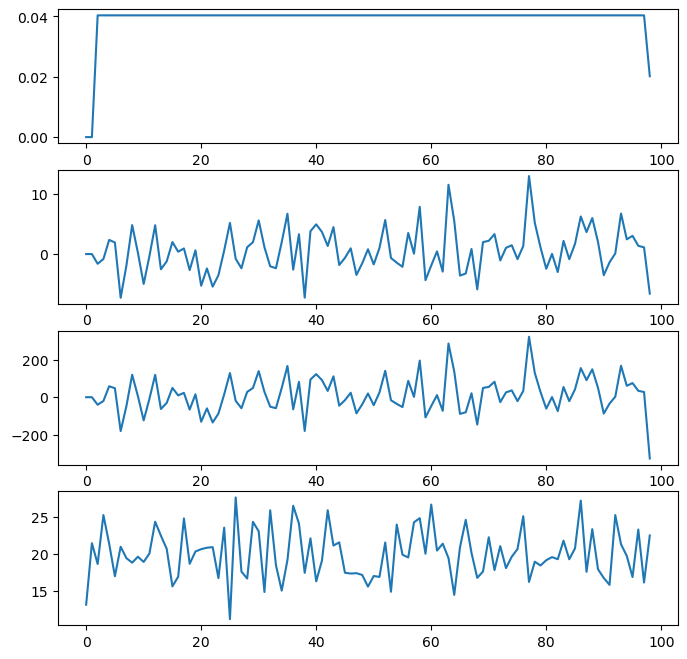

In [126]:
a = 1
b = 100
data = [v/xinv, v, xinv, x]
fig, ax = plt.subplots(len(data),1, figsize=(8,8))
for i in range(len(data)):
    ax[i].plot(data[i][a:b])

(500, 2, 2)

In [52]:
def sample_xz(Gamma, freqs, cut_freq = None):
    if cut_freq is None:
        xs, _, zvecs = sample_bcn_time_obs(Gamma, 1, return_zs=True)
        z = zvecs[0,1,:]
        x = xs[0,:]

    else:
        Gamma_mod = Gamma.copy()
        cut_freq = 50
        cut_ind = np.where(freqs > cut_freq)[0][0]
        # Gamma_mod[cut_ind:,:,:] = 0
        Gamma_mod = Gamma[:cut_ind,:,:]
        xs, _, zvecs = sample_bcn_time_obs(Gamma_mod, 1, return_zs=True)
        z = zvecs[0,1,:]
        x = xs[0,:]

    return x, z


In [67]:
from cohlib.sample import gen_complex_cov, sample_complex_normal
from cohlib.utils import get_freqs, add_zero

def sample_zs_from_Gamma(Gamma, L):
    """Draw L samples from bcn distribution with covariances Z.
    Args:
        Z: (n_freqs, 2, 2), array of complex covs.
        L: number of samples to draw
    Returns:
        z_samples: (L, 2, n_freqs), draws from Z
    """
    n_freqs = Gamma.shape[0]
    z_list = [sample_complex_normal(Gamma[j,:,:], L) for j in range(n_freqs)]
    z_join = np.stack(z_list)
    z_draws = np.swapaxes(z_join, 0, 2)

    return z_draws
